# Description

The notebook simulates the performance of a "pegged-at-mid" trading algorithm.

- Load the 1sec bid/ask data
- Conduct a sanity check
- Calculate the midpoint limit buy/sell prices
- Aggregate to 5T and check the success of trades in historical data

```
dataset_signature=periodic.airflow.downloaded_EOD.parquet.bid_ask.futures.v3.cryptochassis.binance.v1_0_0
```

In [1]:
%load_ext autoreload
%autoreload 2
import logging

import pandas as pd

import core.finance as cofinanc
import core.statistics as costatis
import dataflow.core as dtfcore
import dataflow.system as dtfsys
import helpers.hdbg as hdbg
import helpers.henv as henv
import helpers.hpandas as hpandas
import helpers.hprint as hprint
import research_amp.cc.algotrading as ramccalg

/app/core/statistics/random_samples.py:12: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
One and only one set-up config should be true:
is_cmamp_prod=False
is_dev4=False
is_dev_ck=False
is_ig_prod=False
is_inside_ci=False
is_mac=False
Don't recognize host: host_os_name=Linux, am_host_os_name=Linux


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

_LOG.info("%s", henv.get_system_signature()[0])

hprint.config_notebook()

INFO  > cmd='/venv/lib/python3.9/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-79a2a24c-a4ec-4f78-aeae-6852cd2ada07.json'
INFO  # Git
  branch_name='Make_generate_limit_order_price_function_private'
  hash='3e5d3be97'
  # Last commits:
    * 3e5d3be97 smitpatel49 Make generate_limit_order_price_function private                  (66 minutes ago) Tue Jun 11 19:11:41 2024  (HEAD -> Make_generate_limit_order_price_function_private, origin/Make_generate_limit_order_price_function_private)
    * 18670c511 Juraj Smeriga Add script to maintain local orderbook copy (#1035)               (   9 hours ago) Tue Jun 11 11:10:20 2024  (origin/master, origin/HEAD, master)
    * c3ac308a1 Heanh Sok SorrTask1023_Improve_onboarding_docs (#1030)                      (    3 days ago) Sat Jun 8 16:01:04 2024           
# Machine info
  system=Linux
  node name=018cb4cb0736
  release=6.8.0-31-generic
  version=#31-Ubuntu SMP PREEMPT_DYNAMIC Sat Apr 20 00:40:06 UTC 2024
  ma

# Load CryptoChassis data.

## Initialize MarketData for `read_data` node

In [3]:
# Load the default config.
config = ramccalg.get_default_config()

In [4]:
# Load the historical IM client.
client = ramccalg.get_bid_ask_ImClient(config)
# Load the asset ids of the given universe.
asset_ids = ramccalg.get_universe(config, full_symbols=["binance::ADA_USDT"])
# Set up MarketData for
market_data = ramccalg.get_market_data(config)

## Initialize DAG

In [5]:
start_ts = config.get_and_mark_as_used(("market_data_config", "start_ts"))
end_ts = config.get_and_mark_as_used(("market_data_config", "end_ts"))
intervals = [(start_ts, end_ts)]


def _run_dag_node(dag):
    dag_runner = dtfcore.FitPredictDagRunner(dag)
    dag_runner.set_fit_intervals(intervals)
    fit_result_bundle = dag_runner.fit()
    df = fit_result_bundle.result_df
    return df

In [6]:
# Create an empty DAG.
dag = dtfcore.DAG(mode="strict")
dtfcore.draw(dag)

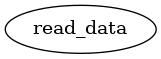

In [7]:
stage = "read_data"
ts_col_name = "end_ts"
multiindex_output = True
col_names_to_remove = []
node = dtfsys.HistoricalDataSource(
    stage,
    market_data,
    ts_col_name,
    multiindex_output,
    col_names_to_remove=col_names_to_remove,
)
dag.insert_at_head(node)
dtfcore.draw(dag)

## Read data

In [8]:
df_original = _run_dag_node(dag)
df_original.shape
df_original.head(5)

run_leq_node:   0%|          | 0/1 [00:00<?, ?it/s]

AssertionError: 
################################################################################
* Failed assertion *
File '/home/.aws/credentials' doesn't exist
################################################################################


In [ ]:
# Drop multiindex in single-asset dataframes for human readability.
if len(asset_ids) < 2:
    df_flat = df_original.droplevel(1, axis=1)
else:
    df_flat = df_original.copy()

In [ ]:
df_flat.head()

## Sanity check

A quick sanity-check for the following:
- What percentage of 1 sec bars are missing?
- How often is bid_size = 0, ask_size = 0, volume=0?
- How often is bid !< ask?


In [ ]:
# Check for missing data.
df_flat.isna().sum()

In [ ]:
# Check for zeroes.
(df_flat == 0).astype(int).sum(axis=1).sum()

In [ ]:
# Check bid price !< ask price.
(df_flat["bid_price"] >= df_flat["ask_price"]).any().any()

In [ ]:
df_flat.head()

In [ ]:
# Check the gaps inside the time series.
index_as_series = df_flat.index.to_series()
freq = "S"
gaps_in_seconds = hpandas.find_gaps_in_time_series(
    index_as_series, start_ts, end_ts, freq
)
gaps_in_seconds = gaps_in_seconds.to_series()

In [ ]:
gaps_percent = len(gaps_in_seconds) / (len(df_flat) + len(gaps_in_seconds)) * 100
average_gap = gaps_in_seconds.diff().mean()
print(
    f"Overall {len(gaps_in_seconds)} gaps were found, \
for {gaps_percent}%% of all seconds in the given period, for an average frequency of {average_gap}"
)

In [ ]:
# Display gaps distribution by hour.
gaps_in_seconds.groupby(gaps_in_seconds.dt.hour).count().plot(kind="bar")

### Commentary

- No NaNs or zeroes were found with a simple general check, there is no need for an in-depth look.
- 575 gaps were found, that mostly concentrate between 0am and 5am.

## Augment data with new features

In [ ]:
# Append `mid` data.
# # (bid + ask) / 2.
bid_col = "bid_price"
ask_col = "ask_price"
bid_volume_col = "bid_size"
ask_volume_col = "ask_size"
requested_cols = ["mid", "ask_value", "bid_value"]
join_output_with_input = True
df_mid = cofinanc.process_bid_ask(
    df_flat,
    bid_col,
    ask_col,
    bid_volume_col,
    ask_volume_col,
    requested_cols=requested_cols,
    join_output_with_input=join_output_with_input,
)
df_mid.head(10)

In [ ]:
print(df_mid.shape)
print(df_mid.index.min())
print(df_mid.index.max())

In [ ]:
df_features = df_mid.copy()

In [ ]:
# Take the mean top-of-book value per hour (rather than the sum, since these are not transactions).
# Typical top-of-book value is on the order of $50k.
df_features[["bid_value", "ask_value"]].resample("1H").mean().plot()

In [ ]:
mid_col_name = "mid"
debug_mode = True
resample_freq = "1T"
abs_spread = 0.0001
df_limit_order_prices = ramccalg.add_limit_order_prices(
    df_features, mid_col_name, debug_mode, abs_spread=abs_spread
)

### Check missing data indices

In [ ]:
print(df_features.shape)

In [ ]:
print(df_limit_order_prices.shape)

In [ ]:
diff = df_limit_order_prices.index.difference(df_features.index)

In [ ]:
df_limit_order_prices.loc[diff]

In [ ]:
df_flat.loc[
    pd.Timestamp("2022-12-13 22:25:59-05:00") : pd.Timestamp(
        "2022-12-13 22:27:00-05:00"
    )
]

#### Commentary

As we have seen during the sanity check above, missing data can congregate around certain time points.

For the 4 missing minutes were minutes where the initial second was missing, and then added in the function due to resampling.

In [ ]:
ramccalg.perform_spread_analysis(
    df_limit_order_prices, "ask_price", "bid_price", "mid"
)

In [ ]:
ramccalg.plot_limit_orders(df_limit_order_prices)

## Resample to T_reprice

In [ ]:
report_stats = True
reprice_df = ramccalg.compute_repricing_df(df_limit_order_prices, report_stats)

In [ ]:
reprice_df.shape

In [ ]:
reprice_df.head(5)

## Resample to T_exec

In [ ]:
exec_df = ramccalg.compute_execution_df(reprice_df, report_stats=True)
exec_df.head(5)

## Compare to benchmark price.

In [ ]:
def compute_benchmark_stats(df):
    df["twap_mid_price"] = df["mid"].resample("5T").mean()
    df[["twap_mid_price", "exec_sell_price", "exec_buy_price"]].head(1000).plot()
    return df

In [ ]:
benchmark_df = compute_benchmark_stats(exec_df)

In [ ]:
slippage = exec_df[["twap_mid_price", "exec_sell_price", "exec_buy_price"]]

slippage["sell_slippage_bps"] = (
    (exec_df["exec_sell_price"] - exec_df["twap_mid_price"])
    / exec_df["twap_mid_price"]
    * 1e4
)

# slippage = df["twap_mid_price"] /

slippage["sell_slippage_bps"].hist(bins=21)

print("sell_slippage_bps.mean=", slippage["sell_slippage_bps"].mean())
print("sell_slippage_bps.median=", slippage["sell_slippage_bps"].median())

### Commentary

The quick look into the rate of successful trades indicated that for the given asset (`ADA/USDT`) and the date the successful "buy" order can be met for 16% of the time and a "sell" order is not met at all.

# Generate limit order prices and simulate

In [ ]:
df_flat.head()

In [ ]:
bid_col = "bid_price"
ask_col = "ask_price"
# Price buy limit order with respect to the bid.
buy_reference_price_col = "bid_price"
# Price sell limit order with respect to the ask.
sell_reference_price_col = "ask_price"
# Price orders halfway between near side and midpoint.
buy_spread_frac_offset = 0.25
sell_spread_frac_offset = -0.25
# Reprice orders every minute.
subsample_freq = "1T"
freq_offset = "0T"
# Keep orders in force for one minute.
ffill_limit = 60
tick_decimals = 5
# Generate limit order prices.
limit_orders = cofinanc._generate_limit_order_price(
    df_flat,
    bid_col,
    ask_col,
    buy_reference_price_col,
    sell_reference_price_col,
    buy_spread_frac_offset,
    sell_spread_frac_offset,
    subsample_freq,
    freq_offset,
    ffill_limit,
    tick_decimals,
)

In [ ]:
limit_orders.head()

In [ ]:
limit_orders[["buy_limit_order_price", "sell_limit_order_price"]].tail(
    60 * 60
).plot()

In [ ]:
df_flat_with_limit_orders = pd.concat([df_flat, limit_orders], axis=1)
df_flat_with_limit_orders.head()

In [ ]:
df_flat_with_limit_orders[["bid_price", "ask_price"]].tail(60 * 60).plot()

In [ ]:
executions = cofinanc.estimate_limit_order_execution(
    df_flat_with_limit_orders,
    bid_col,
    ask_col,
    "buy_limit_order_price",
    "sell_limit_order_price",
    "buy_order_num",
    "sell_order_num",
)

In [ ]:
executions.head()

In [ ]:
df_flat.head()

In [ ]:
limit_order_and_execution_df = (
    cofinanc.generate_limit_orders_and_estimate_execution(
        df_flat,
        bid_col,
        ask_col,
        buy_reference_price_col,
        sell_reference_price_col,
        buy_spread_frac_offset,
        sell_spread_frac_offset,
        subsample_freq,
        freq_offset,
        ffill_limit,
        tick_decimals,
    )
)

In [ ]:
limit_order_and_execution_df.head()

In [ ]:
# Average prices over 5-minute bars.
# The previously boolean columns "limit_buy_executed" and "limit_sell_executed" represent
#  percentage of the time an execution was possible during the bar.
bar_executions = limit_order_and_execution_df.resample(
    "5T", closed="right", label="right"
).mean()
bar_executions.head()

In [ ]:
execution_summary_df = pd.concat(
    [limit_order_and_execution_df, df_flat[bid_col], df_flat[ask_col]], axis=1
)

In [ ]:
buy_trade_price_col = "buy_trade_price"
sell_trade_price_col = "sell_trade_price"
execution_quality_df = cofinanc.compute_bid_ask_execution_quality(
    execution_summary_df.resample("5T", label="right", closed="right").mean(),
    bid_col,
    ask_col,
    buy_trade_price_col,
    sell_trade_price_col,
)

In [ ]:
execution_quality_df[
    [
        "sell_trade_midpoint_slippage_bps",
        "buy_trade_midpoint_slippage_bps",
    ]
].hist(bins=31)

In [ ]:
execution_quality_df.apply(costatis.compute_moments)

In [ ]:
bid_ask_midpoint = (0.5 * (df_flat["ask_price"] + df_flat["bid_price"])).rename(
    "bid_ask_midpoint"
)
bar_bid_ask_midpoint = bid_ask_midpoint.resample(
    "5T", closed="right", label="right"
).mean()
bar_executions_with_midpoint = pd.concat(
    [
        bar_executions[["buy_trade_price", "sell_trade_price"]],
        bar_bid_ask_midpoint,
    ],
    axis=1,
)

In [ ]:
bar_executions_with_midpoint.plot()

In [ ]:
# We may also use cofinanc.apply_execution_prices_to_trades()
#  to assign prices to a single column of buys/sells

# Compare with trade data

In [ ]:
import helpers.hdatetime as hdateti
import helpers.hparquet as hparque

In [ ]:
first_timestamp = pd.Timestamp("2022-12-14 17:59:43-05:00")
last_timestamp = pd.Timestamp("2022-12-14 19:00:00-05:00")

In [ ]:
start = hdateti.convert_timestamp_to_unix_epoch(
    pd.Timestamp(first_timestamp), unit="s"
)
end = hdateti.convert_timestamp_to_unix_epoch(
    pd.Timestamp(last_timestamp), unit="s"
)
# Define filters for data period.
# Note(Juraj): it's better from Airflow execution perspective
#  to keep the interval closed: [start, end].
filters = [
    ("timestamp", ">=", start),
    ("timestamp", "<=", end),
    ("currency_pair", "==", "ADA_USDT"),
    # ("level", "==", 1)
]
file_name = "s3://cryptokaizen-data/v3/periodic_daily/airflow/downloaded_1sec/parquet/trades/futures/v3_1/crypto_chassis/binance/v1_0_0/"
df = hparque.from_parquet(file_name, filters=filters, aws_profile="ck")

In [ ]:
df.head()

In [ ]:
df.loc["2022-12-14 17:59:43-05:00":"2022-12-14 19:00:00-05:00"]["price"].plot()

In [ ]:
df.loc["2022-12-14 17:59:43-05:00":"2022-12-14 19:00:00-05:00"]["size"].plot()

In [ ]:
df_flat_with_limit_orders[["bid_price", "ask_price"]].tail(60 * 60).plot()

In [ ]:
size = df.loc["2022-12-14 17:59:43-05:00":"2022-12-14 19:00:00-05:00"]["size"]
bid_ask = df_flat_with_limit_orders[["bid_price", "ask_price"]].tail(60 * 60)
bid_ask.index = bid_ask.index.tz_convert("UTC")

In [ ]:
bid_ask.resample("1s", label="right", closed="right").sum(min_count=1).plot()

In [ ]:
size.resample("1s", label="right", closed="right").sum().plot()